In [1]:
import os
import sys
import random
import warnings

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
from skimage.io import imshow
from skimage.transform import resize

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
im_width = 128
im_height = 128
im_chan = 1
path = 'C:\\Users\\Артемий\\Documents\\Python\\Salt identification\\'

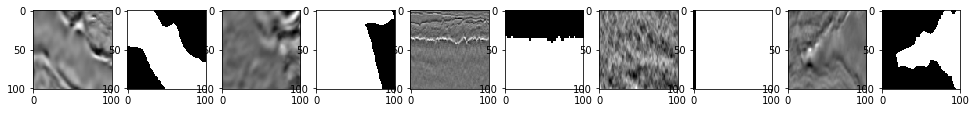

In [3]:
ids= ['0a1742c740','0a19821a16','0aabdb423e','0b45bde756','0b73b427d1']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img(path + 'images\\' + img_name + '.png')
    img_mask = load_img(path + 'masks\\' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [4]:
img_ids = next(os.walk(path + 'images\\'))[2]

In [5]:
X = np.zeros((len(img_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y = np.zeros((len(img_ids), im_height, im_width, 1), dtype=np.bool)

for n, id_ in tqdm(enumerate(img_ids), total=len(img_ids)):
    img = load_img(path + 'images\\' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X[n] = x
    mask = img_to_array(load_img(path + 'masks\\' + id_))[:,:,1]
    Y[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:10<00:00, 56.34it/s]


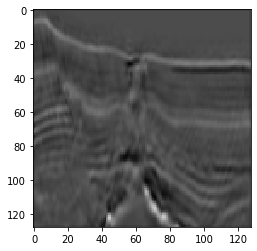

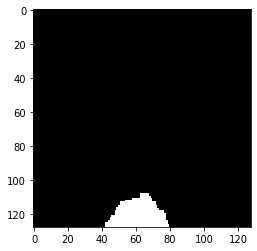

In [19]:
ix = random.randint(0, len(img_ids))
plt.imshow(np.dstack((X[ix],X[ix],X[ix])))
plt.show()
tmp = np.squeeze(Y[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

# Train Model

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.1,random_state=42)

In [8]:
tf.config.experimental_run_functions_eagerly(True)

In [9]:
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

@tf.function(experimental_compile=True)
def train_model(model, X_train, y_train):
    with tf.device('/device:XLA_GPU:0'):
        return model.fit(X_train, y_train, validation_split=0.2, batch_size=8, epochs=10)
    
history = train_model(model, X_train, y_train)

Epoch 1/10
360/360 [==============================] - 148s 412ms/step - loss: 0.5763 - mean_io_u: 0.3731 - val_loss: 0.5659 - val_mean_io_u: 0.3742
Epoch 2/10
360/360 [==============================] - 147s 408ms/step - loss: 0.5617 - mean_io_u: 0.3731 - val_loss: 0.5646 - val_mean_io_u: 0.3742
Epoch 3/10
360/360 [==============================] - 148s 411ms/step - loss: 0.5363 - mean_io_u: 0.3731 - val_loss: 0.5703 - val_mean_io_u: 0.3742
Epoch 4/10
360/360 [==============================] - 148s 410ms/step - loss: 0.4611 - mean_io_u: 0.3735 - val_loss: 0.4068 - val_mean_io_u: 0.3742
Epoch 5/10
360/360 [==============================] - 148s 410ms/step - loss: 0.4035 - mean_io_u: 0.3731 - val_loss: 0.3686 - val_mean_io_u: 0.3742
Epoch 6/10
360/360 [==============================] - 147s 408ms/step - loss: 0.3718 - mean_io_u: 0.3731 - val_loss: 0.3467 - val_mean_io_u: 0.3742
Epoch 7/10
360/360 [==============================] - 147s 408ms/step - loss: 0.3334 - mean_io_u: 0.3743 - val_l

# Test Data
First we'll get the test data. This takes a while, it's 18000 samples.

In [ ]:
y_pred = model.predict(X_test)

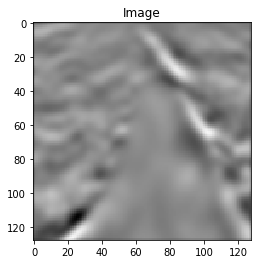

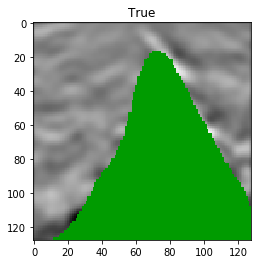

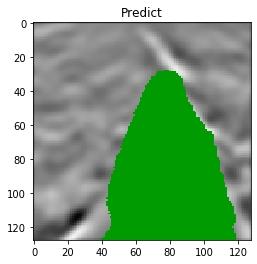

In [96]:
ix = random.randint(0, len(X_test))
plt.title('Image')
plt.imshow(np.dstack((X_test[ix],X_test[ix],X_test[ix])))
plt.show()
plt.title('True')
ch0 = (np.multiply((-1*y_test[ix].astype(np.uint8)+1), X_test[ix])).astype(np.uint8)
ch1 = (np.multiply((-1*y_test[ix].astype(np.uint8)+1), X_test[ix])+y_test[ix].astype(np.uint8)*155).astype(np.uint8)
ch2 = (np.multiply((-1*y_test[ix].astype(np.uint8)+1), X_test[ix])).astype(np.uint8)
plt.imshow(np.dstack((ch0,ch1,ch2)))
plt.show()
plt.title('Predict')
ch0 = (np.multiply((-1*np.around(y_pred[ix])+1), X_test[ix])).astype(np.uint8)
ch1 = (np.multiply((-1*np.around(y_pred[ix])+1), X_test[ix])+np.around(y_pred[ix])*155).astype(np.uint8)
ch2 = (np.multiply((-1*np.around(y_pred[ix])+1), X_test[ix])).astype(np.uint8)
plt.imshow(np.dstack((ch0,ch1,ch2)))
plt.show()